## Preprocessing ephys data for decoding

To decode, we need to:
1. Specify sort time intervals. Table involved: 
2. Remove artifact. Table involved: xx
3. Obtain spikes. Table involved: xx

In [1]:
import os
import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode)
import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

[2023-05-27 11:08:49,594][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-05-27 11:08:49,673][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
nwb_file_name = 'isaac20230519.nwb'
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [3]:
canula_1_tet_list = np.array([11]) - 1
canula_2_tet_list = np.array([20,22,23,24,25]) - 1
all_tet_list = np.concatenate([canula_1_tet_list,canula_2_tet_list])
all_tet_list

array([10, 19, 21, 22, 23, 24])

In [4]:
SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name,'sort_group_id':100}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
isaac20230519_.nwb,100,01_4ms100hz,franklab_tetrode_hippocampus,Xulu Sun,01_4ms100hz


### 1.specify what tetrodes to sort: ```SortGroup```

In [5]:
# NOTE only run this cell the first time you start with a new NWB file
# answer 'yes' when prompted - this will recreate the sort group table for the NWB file
# note: if you say yes to the delete step you will remove all downstream tables

# this is the populate command for the SortGroup table
# it will group the electrodes by tetrodes and associated the reference for each channel
# it will also remove the dead channels - from the yaml file

#SortGroup().set_group_by_shank(nwb_copy_file_name)

In [6]:
# check if dead channels are removed
from spyglass.common import Electrode
print('good electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} & {'bad_channel' : 'False'}).fetch('electrode_group_name').shape)
print('all electrodes',(Electrode() & {'nwb_file_name' : nwb_copy_file_name} ).fetch('electrode_group_name').shape)


good electrodes (128,)
all electrodes (128,)


In [7]:
# find the reference for the 1st canula and the 2nd canula

canula_1_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 0}).fetch('original_reference_electrode')[0]
print('canula 1 ref',canula_1_ref)
canula_2_ref = (Electrode() & {'nwb_file_name' : nwb_copy_file_name} &
       {'electrode_id' : 28*4}).fetch('original_reference_electrode')[0]
print('canula 2 ref',canula_2_ref)

canula 1 ref 32
canula 2 ref 68


In [8]:
# this is a way to make a new sort group that includes several tetrodes that will be used for artifact detection
# we want to make one for each canula 
# tetrodes 1-32 > sort_group_id = 100
# tetrodes 33-64 > sort_group_id = 101
# use the values above for the sort_reference_electrode_id
electrode_list = []
electrode_group_list = []
for tetrode in canula_1_tet_list:
    electrode_list = electrode_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    electrode_group_list = electrode_group_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
#electrode_list
SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                    'sort_group_id' : 100,
                    'sort_reference_electrode_id' : canula_1_ref}, skip_duplicates=True)

for ndx in range(len(electrode_list)):
    electrode_group_name = electrode_group_list[ndx]
    electrode_id = electrode_list[ndx]            
    SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : 100,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)

electrode_list = []
electrode_group_list = []
for tetrode in canula_2_tet_list:
    electrode_list = electrode_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&{'electrode_group_name' : tetrode}&
        {'bad_channel' : 'False'}).fetch('electrode_id').tolist()
    electrode_group_list = electrode_group_list + (Electrode() & {'nwb_file_name' : nwb_copy_file_name}&
                                {'electrode_group_name' : tetrode}&
                                {'bad_channel' : 'False'}).fetch('electrode_group_name').astype(int).tolist()    
#electrode_list
SortGroup.insert1({'nwb_file_name' : nwb_copy_file_name,
                       'sort_group_id' : 101,
                       'sort_reference_electrode_id' : canula_2_ref}, skip_duplicates=True)

for ndx in range(len(electrode_list)):
    electrode_group_name = electrode_group_list[ndx]
    electrode_id = electrode_list[ndx]            
    SortGroup.SortGroupElectrode.insert1({'nwb_file_name' : nwb_copy_file_name,
                                          'sort_group_id' : 101,
                                          'electrode_group_name' : electrode_group_name,
                                          'electrode_id' : electrode_id}, skip_duplicates=True)    
    
    

In [9]:
len((SortGroup & {'nwb_file_name' : nwb_copy_file_name}).fetch('sort_group_id'))

34

### 2. sort intervals: ```SortInterval```,```IntervalList```,```SpikeSortingRecordingSelection```

In [11]:
IntervalList_pd=pd.DataFrame(IntervalList &
             {'nwb_file_name': nwb_copy_file_name})

# select position timestamps, only those on the track are selected
position_interval=[]
for i in IntervalList_pd.index:
    interval=IntervalList_pd['interval_list_name'][i]
    if interval[4:6]=='ms':
        position_interval.append(interval)
    #if interval[-8:-1]=='Session':
    #    position_interval.append('pos '+str(i)+' valid times')

# get times
intvls=[]
for pos_intvl in position_interval:
    intvl=(IntervalList & {'nwb_file_name' : nwb_copy_file_name,
                            'interval_list_name' : pos_intvl}).fetch1('valid_times')
    intvls.append(intvl)
    
    SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : pos_intvl,
                     'sort_interval' : intvl}, skip_duplicates=True)

sort_interval = np.concatenate(intvls)
sort_interval_name = 'spikesort_maze'

# insert new combined interval into BOTH sortinterval table and intervallist table
# try sort interval that has two separate sessions - variable: 'sort interval'
SortInterval.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'sort_interval_name' : sort_interval_name,
                     'sort_interval' : sort_interval}, skip_duplicates=True)
IntervalList.insert1({'nwb_file_name' : nwb_copy_file_name,
                     'interval_list_name' : sort_interval_name,
                     'valid_times' : sort_interval}, skip_duplicates=True)

In [12]:
SortInterval & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_interval_name name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
isaac20230519_.nwb,01_4ms100hz,=BLOB=
isaac20230519_.nwb,02_1ms100hz,=BLOB=
isaac20230519_.nwb,03_1ms200hz,=BLOB=
isaac20230519_.nwb,spikesort_maze,=BLOB=


In [13]:
#np.concatenate([all_tet_list,[100,101]])

In [14]:
sort_interval_name='01_4ms100hz'
def func(tetrode):
    print('create recording for tet',str(tetrode))  
    key = dict()
    key['nwb_file_name'] = nwb_copy_file_name
    key['sort_group_id'] = tetrode
    key['sort_interval_name'] = sort_interval_name
    key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
    key['interval_list_name'] = sort_interval_name
    key['team_name'] = 'Xulu Sun'

    ssr_key1 = key

    SpikeSortingRecordingSelection.insert1(ssr_key1, skip_duplicates=True)
    SpikeSortingRecording.populate([(SpikeSortingRecordingSelection & ssr_key1).proj()])

In [15]:
all_tet_list

array([10, 19, 21, 22, 23, 24])

In [57]:
SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
isaac20230601_.nwb,10,01_200Hz1ms33pulses,franklab_tetrode_hippocampus,Xulu Sun,01_200Hz1ms33pulses
isaac20230601_.nwb,10,02_150Hz1ms29pulses,franklab_tetrode_hippocampus,Xulu Sun,02_150Hz1ms29pulses
isaac20230601_.nwb,10,03_200Hz1ms33pulsesb,franklab_tetrode_hippocampus,Xulu Sun,03_200Hz1ms33pulsesb
isaac20230601_.nwb,10,04_150Hz1ms30pulses,franklab_tetrode_hippocampus,Xulu Sun,04_150Hz1ms30pulses
isaac20230601_.nwb,10,05_200Hz1ms33pulsesc,franklab_tetrode_hippocampus,Xulu Sun,05_200Hz1ms33pulsesc
isaac20230601_.nwb,19,01_200Hz1ms33pulses,franklab_tetrode_hippocampus,Xulu Sun,01_200Hz1ms33pulses
isaac20230601_.nwb,19,02_150Hz1ms29pulses,franklab_tetrode_hippocampus,Xulu Sun,02_150Hz1ms29pulses
isaac20230601_.nwb,19,03_200Hz1ms33pulsesb,franklab_tetrode_hippocampus,Xulu Sun,03_200Hz1ms33pulsesb
isaac20230601_.nwb,19,04_150Hz1ms30pulses,franklab_tetrode_hippocampus,Xulu Sun,04_150Hz1ms30pulses
isaac20230601_.nwb,19,05_200Hz1ms33pulsesc,franklab_tetrode_hippocampus,Xulu Sun,05_200Hz1ms33pulsesc


In [17]:
sort_interval_name='01_4ms100hz'

In [18]:
tetrode=10
print('create recording for tet',str(tetrode))  
key = dict()
key['nwb_file_name'] = nwb_copy_file_name
key['sort_group_id'] = tetrode
key['sort_interval_name'] = sort_interval_name
key['preproc_params_name'] = 'franklab_tetrode_hippocampus'
key['interval_list_name'] = sort_interval_name
key['team_name'] = 'Xulu Sun'

ssr_key1 = key

SpikeSortingRecordingSelection.insert1(ssr_key1, skip_duplicates=True)
SpikeSortingRecording.populate([(SpikeSortingRecordingSelection & ssr_key1).proj()])

create recording for tet 10


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/32 [00:00<?, ?it/s]

In [20]:
all_tet_list

array([10, 19, 21, 22, 23, 24])

In [27]:
sort_interval_name='02_1ms100hz'
for tetrode in all_tet_list:
    func(tetrode)

create recording for tet 10


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

create recording for tet 19


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

create recording for tet 21


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

create recording for tet 22


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

create recording for tet 23


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

create recording for tet 24


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

write_binary_recording with n_jobs = 1 and chunk_size = 299593


write_binary_recording:   0%|          | 0/140 [00:00<?, ?it/s]

In [75]:
# Use GPU #6
#GPU_ID = 0

# use context manager to specify which GPU (device)
#with cp.cuda.Device(GPU_ID):
with multiprocessing.Pool(12) as p:
    p.map(func,list(np.concatenate([all_tet_list,[100,101]])))

create recording for tetcreate recording for tetcreate recording for tetcreate recording for tetcreate recording for tet create recording for tetcreate recording for tetcreate recording for tet   10   21 192223
24100

101






[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,051][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-05-27 11:06:27,052][WARNING]: MySQL server has gone away. Reconnecting to the server.
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (9234, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at mo

write_binary_recordingwrite_binary_recording  with n_jobs =with n_jobs =  8 8and chunk_size = 299593 
and chunk_size = 299593
write_binary_recording write_binary_recordingwrite_binary_recordingwrite_binary_recordingwrite_binary_recordingwrite_binary_recordingwith n_jobs =      with n_jobs =with n_jobs =with n_jobs =with n_jobs =8with n_jobs =      888and chunk_size =88      and chunk_size =and chunk_size =and chunk_size =and chunk_size =299593and chunk_size =     
299593299593299593299593299593






AssertionError: daemonic processes are not allowed to have children

In [58]:
SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
isaac20230601_.nwb,10,01_200Hz1ms33pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_01_200Hz1ms33pulses_10_franklab_tetrode_hippocampus,isaac20230601_.nwb_01_200Hz1ms33pulses_10_franklab_tetrode_hippocampus
isaac20230601_.nwb,10,02_150Hz1ms29pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_02_150Hz1ms29pulses_10_franklab_tetrode_hippocampus,isaac20230601_.nwb_02_150Hz1ms29pulses_10_franklab_tetrode_hippocampus
isaac20230601_.nwb,10,03_200Hz1ms33pulsesb,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_03_200Hz1ms33pulsesb_10_franklab_tetrode_hippocampus,isaac20230601_.nwb_03_200Hz1ms33pulsesb_10_franklab_tetrode_hippocampus
isaac20230601_.nwb,10,04_150Hz1ms30pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_04_150Hz1ms30pulses_10_franklab_tetrode_hippocampus,isaac20230601_.nwb_04_150Hz1ms30pulses_10_franklab_tetrode_hippocampus
isaac20230601_.nwb,10,05_200Hz1ms33pulsesc,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_05_200Hz1ms33pulsesc_10_franklab_tetrode_hippocampus,isaac20230601_.nwb_05_200Hz1ms33pulsesc_10_franklab_tetrode_hippocampus
isaac20230601_.nwb,19,01_200Hz1ms33pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_01_200Hz1ms33pulses_19_franklab_tetrode_hippocampus,isaac20230601_.nwb_01_200Hz1ms33pulses_19_franklab_tetrode_hippocampus
isaac20230601_.nwb,19,02_150Hz1ms29pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_02_150Hz1ms29pulses_19_franklab_tetrode_hippocampus,isaac20230601_.nwb_02_150Hz1ms29pulses_19_franklab_tetrode_hippocampus
isaac20230601_.nwb,19,03_200Hz1ms33pulsesb,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_03_200Hz1ms33pulsesb_19_franklab_tetrode_hippocampus,isaac20230601_.nwb_03_200Hz1ms33pulsesb_19_franklab_tetrode_hippocampus
isaac20230601_.nwb,19,04_150Hz1ms30pulses,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_04_150Hz1ms30pulses_19_franklab_tetrode_hippocampus,isaac20230601_.nwb_04_150Hz1ms30pulses_19_franklab_tetrode_hippocampus
isaac20230601_.nwb,19,05_200Hz1ms33pulsesc,franklab_tetrode_hippocampus,Xulu Sun,/stelmo/nwb/recording/isaac20230601_.nwb_05_200Hz1ms33pulsesc_19_franklab_tetrode_hippocampus,isaac20230601_.nwb_05_200Hz1ms33pulsesc_19_franklab_tetrode_hippocampus


### 3. artifact detection

In [71]:
#dj.ERD(ArtifactDetectionSelection)-3+3

In [11]:
ArtifactDetectionParameters() & {'artifact_params_name': artifact_params_name}

artifact_params_name,artifact_params dictionary of parameters
ampl_500_prop_03_5ms,=BLOB=


In [186]:
param_dict = dict()
param_dict['zscore_thresh'] = None
param_dict['amplitude_thresh'] = 200
param_dict['proportion_above_thresh'] = 0.3
param_dict['removal_window_ms'] = 5
artifact_params_name='ampl_250_prop_03_5ms'
ArtifactDetectionParameters.insert1({'artifact_params_name': artifact_params_name,
                                     'artifact_params': param_dict}, skip_duplicates=True)

In [60]:
sort_interval_name = 'spikesort_maze'
artifact_key = {'nwb_file_name' : nwb_copy_file_name,
                'sort_interval_name' : sort_interval_name,
                'sort_group_id' : 100,
                'preproc_params_name': 'franklab_tetrode_hippocampus',
                'team_name': 'Shijie Gu'}                    
artifact_key['artifact_params_name'] = artifact_params_name

ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)

artifact_key['sort_group_id']=101
ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)

NameError: name 'artifact_params_name' is not defined

In [ ]:
%%capture stored_output
GPU_ID=7
with cp.cuda.Device(GPU_ID):
    ArtifactDetection.populate([(ArtifactDetectionSelection & artifact_key).proj()])


In [ ]:
# do sort_group_id 101 later

In [ ]:
(ArtifactRemovedIntervalList & {'nwb_file_name' : nwb_copy_file_name} )

In [ ]:
stored_output.show()

In [21]:
orig_time_ind[0]

array([191032471])

In [ ]:
# plot data from recording
# tetrodes: [0,1,3,4,6,7,10,12]
import spikeinterface as si

tetrode=3
sort_group = 100
artifact_num = 5
artifact_plot_times = (ArtifactDetection & {'nwb_file_name' : nwb_copy_file_name} & {'sort_interval_name' : sort_interval_name} 
& {'sort_group_id' : sort_group}& {'artifact_params_name': 'ampl_500_prop_03_5ms'}).fetch('artifact_times')[0]
#plottimes = [artifact_plot_times[0][0] + 1227, artifact_plot_times[0][0] + 1229]
plottimes = [artifact_plot_times[artifact_num][0] - 0.05, artifact_plot_times[artifact_num][1] + 0.05]


In [32]:
# plot data from recording
# tetrodes: [0,1,3,4,6,7,10,12]
import spikeinterface as si

tetrode=100
sort_group = 100

recording_path = (SpikeSortingRecording & {'nwb_file_name' : nwb_copy_file_name} & {'sort_interval_name' : sort_interval_name} 
& {'sort_group_id' : tetrode}).fetch1('recording_path')
recording = si.load_extractor(recording_path)
valid_timestamps = SpikeSortingRecording._get_recording_timestamps(recording)
if recording.get_num_segments() > 1 and isinstance(recording, si.AppendSegmentRecording):
    recording = si.concatenate_recordings(recording.recording_list)
elif recording.get_num_segments() > 1 and isinstance(recording, si.BinaryRecordingExtractor):
    recording = si.concatenate_recordings([recording])


eseries_data = recording.get_traces()
#eseries_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1])

In [24]:
artifact_plot_times = (ArtifactDetection & {'nwb_file_name' : nwb_copy_file_name} & {'sort_interval_name' : sort_interval_name} 
& {'sort_group_id' : sort_group}& {'artifact_params_name': 'ampl_500_prop_03_5ms'}).fetch('artifact_times')[0]
#plottimes = [artifact_plot_times[0][0] + 1227, artifact_plot_times[0][0] + 1229]

In [79]:
artifact_time=np.mean(artifact_plot_times,axis=1)

(1650141898.4752865, 1650141898.4802532)

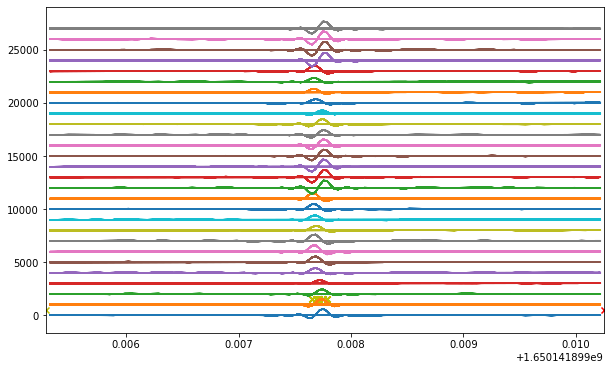

In [191]:
artifact_num = 20
plottimes = [artifact_plot_times[artifact_num][0], artifact_plot_times[artifact_num][1]]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

plt.figure(figsize=(10,6))
for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
    
artifact_plot_times_=valid_timestamps[orig_time_ind][np.argwhere(np.sum(eseries_data[orig_time_ind,:]>200,axis=1)>=12).ravel()]

plt.scatter(artifact_plot_times_, np.repeat(1500,artifact_plot_times_.shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

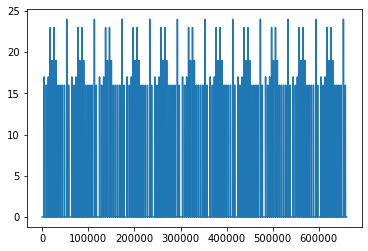

In [169]:
plt.plot(np.sum(eseries_data[orig_time_ind,:]>200,axis=1))

(1650141898.4752865, 1650141898.4802532)

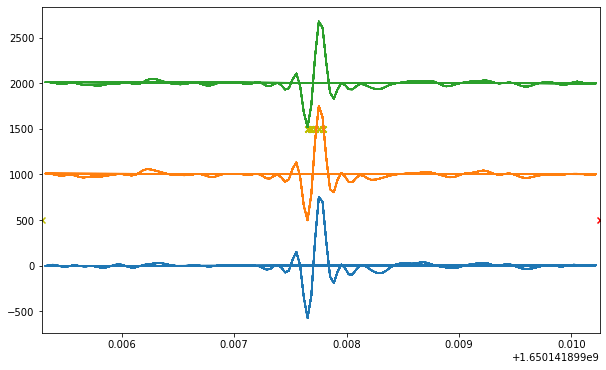

In [192]:
plt.figure(figsize=(10,6))
for i in [25,26,27]:
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+(i-25)*1000)
    
plt.scatter(artifact_plot_times_, np.repeat(1500,artifact_plot_times_.shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [91]:
valid_timestamps[228921343],valid_timestamps[228921344]

(1650156866.382088, 1650135878.0912426)

In [142]:
artifact_ind=np.digitize(artifact_time,np.sort(valid_timestamps))

KeyboardInterrupt: 

In [ ]:
#(SortInterval & {'nwb_file_name' : nwb_copy_file_name,'sort_interval_name' : 'spikesort_maze'}).fetch('sort_interval')[0][6,0]

In [109]:
artifact_ind

array([        0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,         0,         0,         0,         0,
               0,         0,  57380928,  57380928, 

In [71]:
artifact_num = 3
plottimes = [artifact_plot_times[artifact_num][0] - 0.005, artifact_plot_times[artifact_num][1] + 0.005]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

In [64]:
#eseries_data = recording.get_traces(start_frame=orig_time_ind[0], end_frame=orig_time_ind[-1])

In [127]:
np.shape(eseries_data)

(4213342473, 28)

In [128]:
np.shape(valid_timestamps)

(4213342473,)

In [129]:
artifact_time[0]

1650135907.8509383

In [132]:
artifact_plot_times[0,0]

1650135907.848405

In [131]:
valid_timestamps[0]

1650143063.7786002

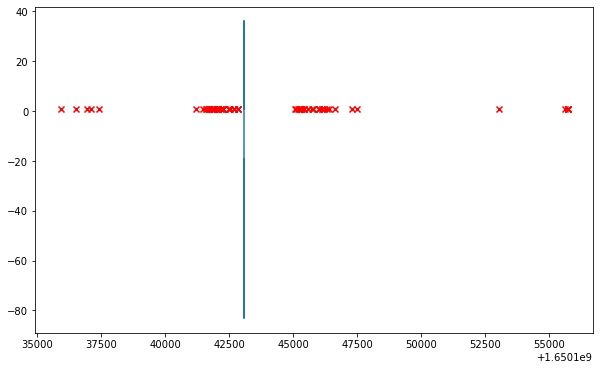

In [130]:
plt.figure(figsize=(10,6))
plt.plot(valid_timestamps[:1000],eseries_data[:1000,0])
plt.scatter(artifact_time,np.ones(np.shape(artifact_time)),marker='x',color='r')

(1650137079.670135, 1650137079.6852353)

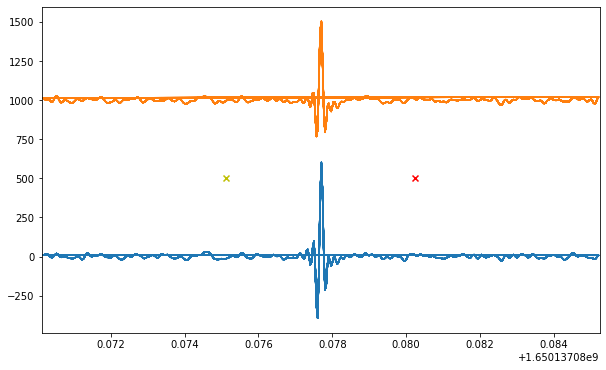

In [72]:
plt.figure(figsize=(10,6))
for i in range(2):
#for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

In [137]:
plottimes

[1650136504.256454, 1650136504.361554]

In [138]:
valid_timestamps[0]

1650143063.7786002

In [141]:
valid_timestamps[orig_time_ind[0]]

1650136504.2564871

(1650136504.256454, 1650136504.361554)

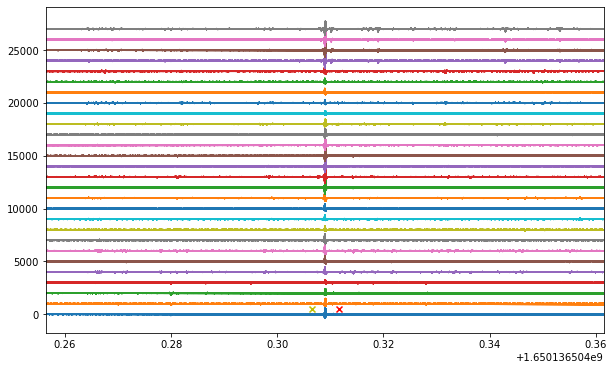

In [135]:
artifact_num = 1
plottimes = [artifact_plot_times[artifact_num][0] - .05, artifact_plot_times[artifact_num][1] + .05]
orig_time_ind = np.argwhere(np.logical_and(valid_timestamps > plottimes[0], valid_timestamps < plottimes[1])).ravel()

plt.figure(figsize=(10,6))
for i in range(np.shape(eseries_data)[1]):
    plt.plot(valid_timestamps[orig_time_ind], eseries_data[orig_time_ind,i]+i*1000)
plt.scatter(artifact_plot_times[:,0], np.repeat(500,artifact_plot_times[:,0].shape[0]),marker='x',color='y')
plt.scatter(artifact_plot_times[:,1], np.repeat(500,artifact_plot_times[:,1].shape[0]),marker='x',color='r')
plt.xlim(plottimes[0],plottimes[1])

### 4. Spikesorting ```SpikeSortingSelection```,```SpikeSorting```

In [4]:
(SpikeSorterParameters() & {'sorter':'clusterless_thresholder','sorter_params_name':'default_clusterless'}).fetch('sorter_params')

array([{'detect_threshold': 100.0, 'method': 'locally_exclusive', 'peak_sign': 'neg', 'n_shifts': 2, 'local_radius_um': 100, 'noise_levels': array([1.]), 'random_chunk_kwargs': {}, 'outputs': 'sorting', 'localization_dict': None}],
      dtype=object)

In [66]:
artifact_params_name='ampl_1000_prop_01'
for tetrode in [3]:    
    artifact_intervals = (ArtifactDetection() 
                          & {'nwb_file_name' : nwb_copy_file_name} 
                          & {'artifact_params_name': artifact_params_name}
                          & {'sort_interval_name':sort_interval_name}
                          & {'sort_group_id' : tetrode}
                         ).fetch('artifact_removed_interval_list_name')[0]
    
    sorting_key = (SpikeSortingRecordingSelection() 
                   & {'nwb_file_name' : nwb_copy_file_name} 
                   & {'sort_interval_name' :sort_interval_name} 
                   & {'sort_group_id' : tetrode}).fetch1('KEY')    
    sorting_key['sorter'] = 'clusterless_thresholder'
    sorting_key['sorter_params_name'] = 'default'
    sorting_key['artifact_removed_interval_list_name'] = artifact_intervals

    SpikeSortingSelection.insert1(sorting_key, skip_duplicates=True)
    SpikeSorting.populate([(SpikeSortingSelection & sorting_key).proj()])

Running spike sorting on {'nwb_file_name': 'molly20220416_.nwb', 'sort_group_id': 3, 'sort_interval_name': 'spikesort_maze', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'Shijie Gu', 'sorter': 'clusterless_thresholder', 'sorter_params_name': 'default', 'artifact_removed_interval_list_name': 'molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_ampl_1000_prop_01_artifact_removed_valid_times'}...
Saving sorting results...


In [68]:
SpikeSorting & {'nwb_file_name' : nwb_copy_file_name} 

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
molly20220416_.nwb,3,spikesort_maze,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_ampl_1000_prop_01_artifact_removed_valid_times,/stelmo/nwb/sorting/molly20220416_.nwb_spikesort_maze_3_franklab_tetrode_hippocampus_d2665606_spikesorting,1653405828
